In [1]:
# Imports
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
from pathlib import Path
import string
import pandas as pd
import numpy as np
import seaborn as sns
import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
pn.extension('plotly')
from pytrends.request import TrendReq

In [2]:
# Loads .env
load_dotenv()

True

In [3]:
# Sets Alpaca API key and secret
alpaca_key = os.getenv('ALPACA_API_KEY')
alpaca_secret = os.getenv('ALPACA_API_SECRET')

# Creates the Alpaca API object
alpaca = tradeapi.REST(alpaca_key, alpaca_secret, api_version = "v2")
timeframe = "1D"
start = pd.Timestamp('2016-05-26', tz = 'US/Pacific').isoformat()
end = pd.Timestamp('2021-06-6', tz = 'US/Pacific').isoformat()

In [4]:
# Declares Global Variables
pytrend = TrendReq()

sectors = [
    'Communications',
    'Consumer Discretionary',
    'Consumer Staples',
    'Energy',
    'Financial',
    'Healthcare',
    'Industrial',
    'Information Technology',
    'Materials',
    'Real Estate',
    'Utilities'
    ]

beta = ['Min', 'Max', 'Median', 'Mutual Fund']

z_field = ['Close', 'Volume']

sector_tickers = {
    'Communications':
        {'Min': 'VZ', 'Max': 'LYV', 'Median': 'TMUS', 'Mutual Fund': 'VOX'},
    'Consumer Discretionary':
        {'Min': 'NVR', 'Max': 'F', 'Median': 'HLT', 'Mutual Fund': 'VCR'},
    'Consumer Staples':
        {'Min': 'CLX', 'Max': 'SYY', 'Median': 'PM', 'Mutual Fund': 'VDC'},
    'Energy':
        {'Min': 'COG', 'Max': 'OXY', 'Median': 'SLB', 'Mutual Fund': 'VDE'},
    'Financial':
        {'Min': 'CBOE', 'Max': 'LNC', 'Median': 'BAC', 'Mutual Fund': 'VFH'},
    'Healthcare':
        {'Min': 'DGX', 'Max': 'ALGN', 'Median': 'CAH', 'Mutual Fund': 'VHT'},
    'Industrial':
        {'Min': 'DGX', 'Max': 'TDG', 'Median': 'DE', 'Mutual Fund': 'VIS'},
    'Information Technology':
        {'Min': 'ORCL', 'Max': 'ENPH', 'Median': 'NTAP', 'Mutual Fund': 'VGT'},
    'Materials':
        {'Min': 'NEM', 'Max': 'FCX', 'Median': 'AVY', 'Mutual Fund': 'VAW'},
    'Real Estate':
        {'Min': 'PSA', 'Max': 'SPG', 'Median': 'UDR', 'Mutual Fund': 'VNQ'},
    'Utilities':
        {'Min': 'ED', 'Max': 'AES', 'Median': 'SRE', 'Mutual Fund': 'VPU'}
}

member_picks = {
'Boomer': ['VDC', 'VNQ', 'VOX', 'VAW'],
'Stonks': ['GME', 'AMC', 'PSLV', 'BB'],
'Pro Gamer': ['AAPL', 'TSLA', 'AMC', 'WMT'],
'Real American': ['LMT', 'TAP', 'PM', 'HAL']
}

In [5]:
# Read S & P 500 data to dataframe
sp_file = Path('../Data/SP500.csv')
sp_df = pd.read_csv(sp_file, infer_datetime_format=True, parse_dates=True, index_col='Date')
sp_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-06-08 16:00:00,3199.92,3233.13,3196.00,3232.39,3698462911
2020-06-09 16:00:00,3213.32,3222.71,3193.11,3207.18,3156921516
2020-06-10 16:00:00,3213.42,3223.27,3181.49,3190.14,3568860875
2020-06-11 16:00:00,3123.53,3123.53,2999.49,3002.10,4123277874
2020-06-12 16:00:00,3071.04,3088.42,2984.47,3041.31,3385763024


In [61]:
# Read Max beta for each sector into dataframe
sectors_max_df = pd.DataFrame()
sectors_max_df['SP500'] = sp_df['Close']
for k, v in sector_tickers.items():
        ticker = sector_tickers[k]['Max']
        file = Path('../Data/{}.csv'.format(ticker))
        ticker_df = pd.read_csv(file, infer_datetime_format=True, parse_dates=True, index_col='Date')
        sectors_max_df[k] = ticker_df['Close']
sectors_max_df = sectors_max_df.pct_change()
sectors_max_df.dropna(inplace=True)
sectors_max_df.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.001126,0.002162,0.003349,0.001164,0.001763,0.001986,0.003333,0.001412,0.004984,0.005786,0.001877,0.002284
std,0.010690,0.027874,0.026513,0.024749,0.046429,0.034644,0.034536,0.021640,0.049641,0.033240,0.034639,0.022170
min,-0.058944,-0.090320,-0.099853,-0.071673,-0.161368,-0.128966,-0.109433,-0.087881,-0.260045,-0.136007,-0.133598,-0.075484
25%,-0.004382,-0.013194,-0.012871,-0.010530,-0.027562,-0.017998,-0.014353,-0.010029,-0.023835,-0.012984,-0.016910,-0.009052
50%,0.001673,-0.000610,0.000000,0.000534,0.000000,0.001362,0.001491,0.000975,0.005443,0.003052,0.002358,0.002237
75%,0.008072,0.015702,0.018854,0.013222,0.028327,0.021488,0.017570,0.014710,0.034808,0.026797,0.018745,0.014732
max,0.023791,0.148465,0.085090,0.167926,0.221778,0.251247,0.349662,0.091957,0.171107,0.108696,0.278694,0.074675


In [62]:
# Read Min beta for each sector into dataframe
sectors_min_df = pd.DataFrame()
sectors_min_df['SP500'] = sp_df['Close']
for k, v in sector_tickers.items():
        ticker = sector_tickers[k]['Min']
        file = Path('../Data/{}.csv'.format(ticker))
        ticker_df = pd.read_csv(file, infer_datetime_format=True, parse_dates=True, index_col='Date')
        sectors_min_df[k] = ticker_df['Close']
sectors_min_df = sectors_min_df.pct_change()
sectors_min_df.dropna(inplace=True)
sectors_min_df.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.001126,-0.000007,0.001470,-0.000289,-0.000831,0.000488,0.000518,0.000518,0.001741,0.001211,0.001432,0.000061
std,0.010690,0.009756,0.021537,0.015919,0.023596,0.018668,0.015866,0.015866,0.015012,0.020394,0.014088,0.013074
min,-0.058944,-0.031667,-0.094058,-0.106245,-0.077063,-0.058452,-0.070312,-0.070312,-0.065308,-0.073943,-0.046464,-0.045813
25%,-0.004382,-0.004414,-0.010055,-0.007251,-0.017126,-0.011214,-0.008148,-0.008148,-0.005875,-0.011291,-0.006348,-0.007541
50%,0.001673,0.000000,0.000919,0.000000,-0.001030,0.000513,0.002049,0.002049,0.001618,0.000000,0.002148,0.000982
75%,0.008072,0.004771,0.014740,0.007222,0.015115,0.012246,0.009372,0.009372,0.009027,0.013875,0.010880,0.008484
max,0.023791,0.052447,0.106816,0.047492,0.063123,0.083343,0.043889,0.043889,0.066453,0.070478,0.053854,0.037042


In [63]:
# Read Median beta for each sector into dataframe
sectors_med_df = pd.DataFrame()
sectors_med_df['SP500'] = sp_df['Close']
for k, v in sector_tickers.items():
        ticker = sector_tickers[k]['Median']
        file = Path('../Data/{}.csv'.format(ticker))
        ticker_df = pd.read_csv(file, infer_datetime_format=True, parse_dates=True, index_col='Date')
        sectors_med_df[k] = ticker_df['Close']
sectors_med_df = sectors_med_df.pct_change()
sectors_med_df.dropna(inplace=True)
sectors_med_df.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.001126,0.001431,0.001563,0.001022,0.002273,0.001896,4.530280e-08,0.003155,0.002296,0.002438,0.000749,0.000171
std,0.010690,0.016625,0.022476,0.014210,0.033504,0.021897,1.946138e-02,0.018604,0.024561,0.018209,0.020397,0.015713
min,-0.058944,-0.061944,-0.063262,-0.057939,-0.116889,-0.100376,-7.795139e-02,-0.061553,-0.144753,-0.077803,-0.062267,-0.058687
25%,-0.004382,-0.007158,-0.011839,-0.006745,-0.018737,-0.009904,-1.051589e-02,-0.006230,-0.008666,-0.008878,-0.010223,-0.008233
50%,0.001673,0.001408,0.000480,0.001054,0.002238,0.001725,0.000000e+00,0.002514,0.002729,0.002805,0.000475,-0.000579
75%,0.008072,0.011918,0.013318,0.008456,0.020787,0.014395,1.079395e-02,0.013063,0.015229,0.014628,0.011676,0.009955
max,0.023791,0.064662,0.122253,0.047020,0.199080,0.141917,7.322006e-02,0.099084,0.093612,0.066799,0.138126,0.048930


In [64]:
# Read Mutual Fund beta for each sector into dataframe
sectors_mut_df = pd.DataFrame()
sectors_mut_df['SP500'] = sp_df['Close']
for k, v in sector_tickers.items():
        ticker = sector_tickers[k]['Mutual Fund']
        file = Path('../Data/{}.csv'.format(ticker))
        ticker_df = pd.read_csv(file, infer_datetime_format=True, parse_dates=True, index_col='Date')
        sectors_mut_df[k] = ticker_df['Close']
sectors_mut_df = sectors_mut_df.pct_change()
sectors_mut_df.dropna(inplace=True)
sectors_mut_df.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.001126,0.001478,0.001588,0.000743,0.001167,0.001558,0.000775,0.001421,0.001404,0.001690,0.000742,0.000203
std,0.010690,0.012540,0.013144,0.008231,0.025370,0.015505,0.010287,0.013150,0.015323,0.014259,0.012415,0.010968
min,-0.058944,-0.049505,-0.057409,-0.039592,-0.095902,-0.081827,-0.055343,-0.074236,-0.059138,-0.081771,-0.064198,-0.041406
25%,-0.004382,-0.004992,-0.006390,-0.003614,-0.014449,-0.008024,-0.004764,-0.005858,-0.006960,-0.005471,-0.006230,-0.007202
50%,0.001673,0.002338,0.003032,0.000588,0.000399,0.001969,0.000215,0.001821,0.002664,0.001479,0.001578,0.000077
75%,0.008072,0.008894,0.010936,0.006040,0.016262,0.011579,0.006981,0.009539,0.011416,0.011002,0.008367,0.007399
max,0.023791,0.040685,0.031815,0.022781,0.141252,0.080195,0.044054,0.034943,0.039537,0.043257,0.035843,0.028701


In [49]:
max_corr = sectors_max_df.corr()
min_corr = sectors_min_df.corr()
med_corr = sectors_med_df.corr()
mut_corr = sectors_mut_df.corr()

In [50]:
max_corr

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
SP500,1.000000,0.494547,0.421255,0.499110,0.414304,0.489579,0.481323,0.583471,0.368853,0.546533,0.449961,0.500361
Communications,0.494547,1.000000,0.417771,0.647942,0.462516,0.617254,0.301957,0.602697,0.207770,0.364192,0.685917,0.421254
Consumer Discretionary,0.421255,0.417771,1.000000,0.466207,0.445132,0.545433,0.276483,0.527178,0.146087,0.409720,0.503573,0.380177
Consumer Staples,0.499110,0.647942,0.466207,1.000000,0.557671,0.686156,0.283877,0.647524,0.097707,0.384811,0.731634,0.407377
Energy,0.414304,0.462516,0.445132,0.557671,1.000000,0.641906,0.255158,0.498801,0.188993,0.473866,0.590537,0.385856
Financial,0.489579,0.617254,0.545433,0.686156,0.641906,1.000000,0.287810,0.656683,0.145064,0.480152,0.755610,0.401385
Healthcare,0.481323,0.301957,0.276483,0.283877,0.255158,0.287810,1.000000,0.366709,0.283779,0.329580,0.243399,0.340060
Industrial,0.583471,0.602697,0.527178,0.647524,0.498801,0.656683,0.366709,1.000000,0.259773,0.496792,0.596426,0.520094
Information Technology,0.368853,0.207770,0.146087,0.097707,0.188993,0.145064,0.283779,0.259773,1.000000,0.228590,0.107808,0.364061
Materials,0.546533,0.364192,0.409720,0.384811,0.473866,0.480152,0.329580,0.496792,0.228590,1.000000,0.359342,0.390607


In [51]:
max_corr.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.520775,0.518652,0.461585,0.534168,0.492895,0.558919,0.370845,0.563012,0.283207,0.455349,0.534298,0.458217
std,0.161721,0.209769,0.202247,0.234097,0.205205,0.223620,0.208026,0.178913,0.242866,0.191560,0.245242,0.178391
min,0.368853,0.207770,0.146087,0.097707,0.188993,0.145064,0.243399,0.259773,0.097707,0.228590,0.107808,0.340060
25%,0.442785,0.404376,0.402334,0.401736,0.407192,0.460460,0.281955,0.498298,0.145831,0.362980,0.380365,0.384436
50%,0.492063,0.478532,0.433193,0.528390,0.468191,0.581344,0.294884,0.555324,0.218180,0.400164,0.547055,0.395996
75%,0.511904,0.624926,0.509474,0.657496,0.565887,0.664051,0.346722,0.613903,0.303850,0.484312,0.697346,0.441031
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
min_corr

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
SP500,1.000000,0.382144,0.551580,0.053693,0.161941,0.293621,0.203931,0.203931,0.452863,0.361519,0.275119,0.230779
Communications,0.382144,1.000000,0.281040,0.142660,0.163350,0.213090,0.056277,0.056277,0.327413,0.157224,0.215324,0.426117
Consumer Discretionary,0.551580,0.281040,1.000000,0.187437,0.077995,0.127208,0.222371,0.222371,0.315094,0.232000,0.272143,0.229853
Consumer Staples,0.053693,0.142660,0.187437,1.000000,0.058905,-0.068338,0.183530,0.183530,0.171654,0.255595,0.266918,0.166715
Energy,0.161941,0.163350,0.077995,0.058905,1.000000,0.126101,0.079197,0.079197,0.106091,0.043352,0.045356,0.143683
Financial,0.293621,0.213090,0.127208,-0.068338,0.126101,1.000000,0.098573,0.098573,0.164748,0.062760,0.167966,0.101096
Healthcare,0.203931,0.056277,0.222371,0.183530,0.079197,0.098573,1.000000,1.000000,0.089697,0.166612,0.083869,0.172380
Industrial,0.203931,0.056277,0.222371,0.183530,0.079197,0.098573,1.000000,1.000000,0.089697,0.166612,0.083869,0.172380
Information Technology,0.452863,0.327413,0.315094,0.171654,0.106091,0.164748,0.089697,0.089697,1.000000,0.194458,0.266511,0.254152
Materials,0.361519,0.157224,0.232000,0.255595,0.043352,0.062760,0.166612,0.166612,0.194458,1.000000,0.143413,0.126481


In [53]:
min_corr.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.347594,0.285076,0.309924,0.216858,0.173764,0.198783,0.279703,0.279703,0.286032,0.242502,0.266078,0.283007
std,0.245625,0.253777,0.246223,0.263435,0.263614,0.266824,0.340804,0.340804,0.249943,0.253089,0.250897,0.245680
min,0.053693,0.056277,0.077995,-0.068338,0.043352,-0.068338,0.056277,0.056277,0.089697,0.043352,0.045356,0.101096
25%,0.203931,0.153583,0.213637,0.121721,0.073223,0.098573,0.088240,0.088240,0.150084,0.139180,0.128527,0.160957
50%,0.284370,0.214207,0.230927,0.177592,0.092644,0.126654,0.169496,0.169496,0.224305,0.166612,0.240917,0.201117
75%,0.399824,0.341096,0.289554,0.204477,0.148247,0.179247,0.208541,0.208541,0.318174,0.237899,0.272887,0.283726
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
med_corr

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
SP500,1.000000,0.554326,0.524280,0.468494,0.439434,0.511104,0.439103,0.515777,0.533574,0.572249,0.458302,0.448171
Communications,0.554326,1.000000,0.195234,0.221677,0.106759,0.173369,0.097515,0.226343,0.116497,0.261873,0.127863,0.219373
Consumer Discretionary,0.524280,0.195234,1.000000,0.373769,0.512705,0.592946,0.387068,0.431172,0.399911,0.464807,0.548809,0.445628
Consumer Staples,0.468494,0.221677,0.373769,1.000000,0.418451,0.403003,0.361608,0.333367,0.317635,0.398527,0.354065,0.389224
Energy,0.439434,0.106759,0.512705,0.418451,1.000000,0.660051,0.448348,0.418780,0.422806,0.457433,0.496569,0.335326
Financial,0.511104,0.173369,0.592946,0.403003,0.660051,1.000000,0.479857,0.496912,0.424018,0.511475,0.559705,0.335625
Healthcare,0.439103,0.097515,0.387068,0.361608,0.448348,0.479857,1.000000,0.446569,0.368784,0.392222,0.352971,0.365676
Industrial,0.515777,0.226343,0.431172,0.333367,0.418780,0.496912,0.446569,1.000000,0.392422,0.513909,0.347589,0.319529
Information Technology,0.533574,0.116497,0.399911,0.317635,0.422806,0.424018,0.368784,0.392422,1.000000,0.372280,0.397651,0.263461
Materials,0.572249,0.261873,0.464807,0.398527,0.457433,0.511475,0.392222,0.513909,0.372280,1.000000,0.403923,0.366379


In [55]:
med_corr.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.538734,0.275069,0.489694,0.419985,0.476388,0.512339,0.428310,0.453531,0.417420,0.476256,0.464783,0.418195
std,0.152271,0.258562,0.190935,0.192510,0.208503,0.198987,0.204574,0.192768,0.209524,0.184353,0.206276,0.201317
min,0.439103,0.097515,0.195234,0.221677,0.106759,0.173369,0.097515,0.226343,0.116497,0.261873,0.127863,0.219373
25%,0.455769,0.125021,0.396700,0.348891,0.418698,0.418765,0.364659,0.344034,0.355997,0.387237,0.353791,0.331377
50%,0.513440,0.207303,0.455217,0.381497,0.443891,0.504008,0.389645,0.424976,0.395037,0.430678,0.431112,0.366027
75%,0.538762,0.235226,0.530412,0.406865,0.500603,0.568015,0.447014,0.501161,0.423109,0.512084,0.534664,0.446263
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
mut_corr

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
SP500,1.000000,0.863260,0.886224,0.770827,0.503089,0.682066,0.818268,0.791843,0.869074,0.759255,0.716362,0.529409
Communications,0.863260,1.000000,0.796212,0.628003,0.319540,0.458061,0.641708,0.550148,0.801535,0.521332,0.570708,0.405835
Consumer Discretionary,0.886224,0.796212,1.000000,0.623034,0.360962,0.531254,0.689467,0.680599,0.838353,0.653725,0.614783,0.388729
Consumer Staples,0.770827,0.628003,0.623034,1.000000,0.436945,0.578566,0.649939,0.690276,0.529320,0.674082,0.671014,0.660190
Energy,0.503089,0.319540,0.360962,0.436945,1.000000,0.777527,0.369775,0.701460,0.196047,0.653329,0.507379,0.306982
Financial,0.682066,0.458061,0.531254,0.578566,0.777527,1.000000,0.515486,0.870220,0.326918,0.784123,0.645871,0.481622
Healthcare,0.818268,0.641708,0.689467,0.649939,0.369775,0.515486,1.000000,0.644798,0.690543,0.632698,0.575379,0.474158
Industrial,0.791843,0.550148,0.680599,0.690276,0.701460,0.870220,0.644798,1.000000,0.487331,0.899459,0.713172,0.527349
Information Technology,0.869074,0.801535,0.838353,0.529320,0.196047,0.326918,0.690543,0.487331,1.000000,0.478752,0.485871,0.284911
Materials,0.759255,0.521332,0.653725,0.674082,0.653329,0.784123,0.632698,0.899459,0.478752,1.000000,0.628033,0.471824


In [57]:
mut_corr.describe()

,SP500,Communications,Consumer Discretionary,Consumer Staples,Energy,Financial,Healthcare,Industrial,Information Technology,Materials,Real Estate,Utilities
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.765806,0.629695,0.671945,0.659350,0.511086,0.637643,0.641852,0.713055,0.582388,0.679718,0.648063,0.514933
std,0.143770,0.201449,0.190635,0.136538,0.232023,0.193375,0.161449,0.155603,0.255264,0.160418,0.132174,0.191436
min,0.503089,0.319540,0.360962,0.436945,0.196047,0.326918,0.369775,0.487331,0.196047,0.471824,0.485871,0.284911
25%,0.707788,0.505514,0.593901,0.611917,0.350607,0.507020,0.560405,0.621136,0.440794,0.601358,0.574211,0.401559
50%,0.781335,0.599355,0.667162,0.655065,0.470017,0.612218,0.643253,0.695868,0.508325,0.653527,0.636952,0.477890
75%,0.864714,0.797543,0.806748,0.678130,0.665362,0.779176,0.689736,0.811438,0.810739,0.765472,0.681554,0.559104
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


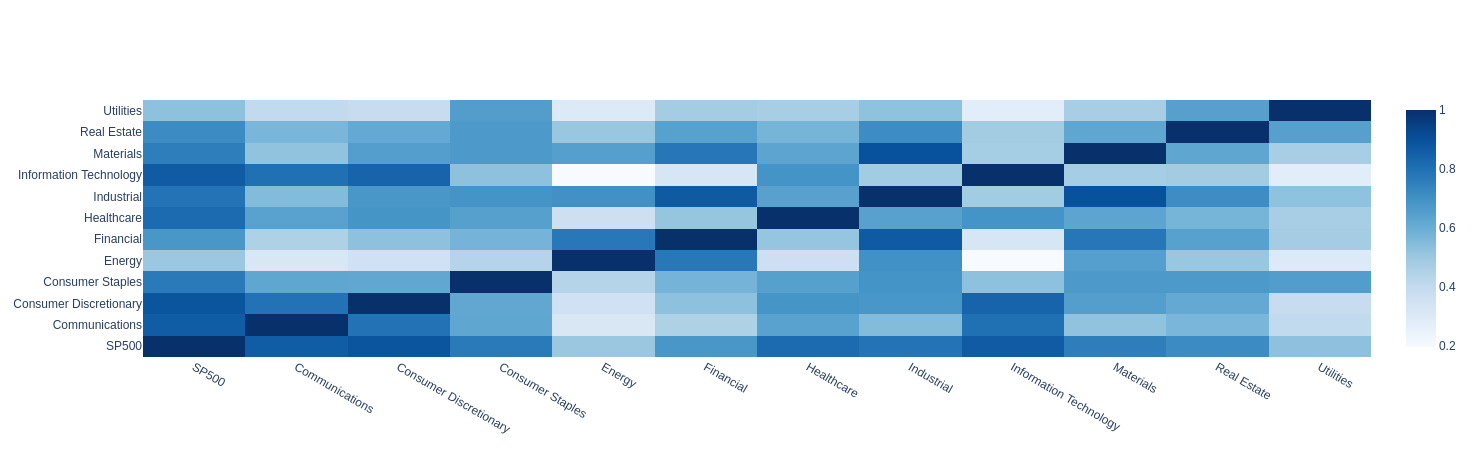

In [60]:
def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist()}
fig = go.Figure(data=go.Heatmap(
        df_to_plotly(mut_corr),
        colorscale='blues'))
fig.show()